my work-in-progress(WIP) notebook for cvmio.py 

In [2]:
import pdb
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import utm
from nllgrid import NLLGrid

In [2]:
#Path to the binaryCVM
path = '/Users/banjo/Projects/nll_pnsn/velocityModels/binaryCVM' 

## Part 1: Make a SubModel of the CVM (erin and ian's func)

In [3]:
def readBinary(zTop=0, zBot=1200,
               min_utme=None, max_utme=None,
               min_utmn=None, max_utmn=None,
               newModelName='subModel.nc',
               binModelName='',
               saveFull='N'):
    """
    Read in 3-D CVM from binary files.

    This function only works with one binary file at a time.
    Input parameters are used to specify bounds of a sub-model,
    if only a small chunk of the full CVM is needed.

    Offshore water is set to V=1e20 in binary files.

    All UTM coordinates are given for Zone 10T.

    For Puget Lowland: zTop=0, zBot=200,
               min_utme=446700, max_utme=567100,
               min_utmn=5194300, max_utmn=5316700,
               modelName='subModel_0_200m_PL.nc'

    Parameters:
    zTop: Top of sub-model [m]
    zBot: Bottom of sub-model [m]
    min_utme: Minimum easting [m]
    max_utme: Maximum easting [m]
    min_utmn: Minimum northing [m]
    max_utmn: Maximum northing [m]

    Returns:
    subModelxr: Sub-model in xarray format

    """

    # The following lines describe the size of the binary file values.
    #
    # Layer 1 0-1200m depth
    # 3271 in EW direction
    # 5367 in NS direction
    # 13 in z
    # dx=dy= 200m,  dz= 100m
    #
    if 'l1' in binModelName:
        nx = 3271; ny = 5367; nz = 13
        dx = 200;  dy = 200;  dz = 100
        zmin = 0; zmax = 1200
   
    # Layer 2 1500-9900m depth
    # 2181 in EW
    # 3578 in NS
    # 29 in z
    # dx=dy=dz=300m
    #
    if 'l2' in binModelName:
        nx = 2181; ny = 3578; nz = 29
        dx = 300;  dy = 300;  dz = 300
        zmin = 1500; zmax = 9900
    #
    # Layer 3 10800-59400m depth
    # 727 in EW
    # 1193 NS
    # 55 in z
    # dx=dy=dz=900m
    #
    if 'l3' in binModelName:
        nx = 727; ny = 1193; nz = 55
        dx = 900; dy = 900;  dz = 900
        zmin = 10800; zmax = 59400
    #
    # The SW corner of the velocity model is -10800m East, 4467300m N Zone 10.
    SWcornerFull = [-10800, 4467300]
    #

    # Read in binary file
    v = np.fromfile(binModelName, dtype='<f4')

    # Generate arrays for x, y, & z locations
    z = np.linspace(zmin, zmax, nz)
    z = np.repeat(z, (np.ones(len(z))*nx*ny).astype(int))
    z = z[::-1]             # Reverse array

    y = np.linspace(SWcornerFull[1], SWcornerFull[1]+ny*dy, ny, endpoint=False)
    y = np.repeat(y, (np.ones(len(y))*nx).astype(int))
    y = np.tile(y, nz)     # Repeat array for each depth

    x = np.linspace(SWcornerFull[0], SWcornerFull[0]+nx*dx, nx, endpoint=False)
    x = np.tile(x, ny*nz)

    # Convert CVM to dataframe
#     model = pd.DataFrame(np.column_stack((x,y,z,v)), columns=['utme','utmn','z',(binModelName.split('/'))[1].split('_16')[0]])
    model = pd.DataFrame(np.column_stack((x,y,z,v)), columns=['utme','utmn','z','vp'])

    if saveFull == 'N' or saveFull == 'n':
        # Subset model (speed things up)
        if min_utme==None:
            # Use full horizontal model extent
            subModel = model[(model["z"] >= zTop) & (model["z"] <= zBot)]
        else:
            subModel = model[(model["z"] >= zTop) & (model["z"] <= zBot)
                             & (model["utme"] >= min_utme) & (model["utme"] <= max_utme)
                             & (model["utmn"] >= min_utmn) & (model["utmn"] <= max_utmn)]
        subModel = subModel.set_index(['utme','utmn','z'])    # Set these parameters as coordinates

        # Convert to xarray (slow)
        subModelxr = subModel.to_xarray()

        # Save xarray for faster reload later
        subModelxr.to_netcdf('../output/' + newModelName)

        return subModelxr

    # This can be VERY slow (~ 1 hour)
    if saveFull == 'Y' or saveFull == 'y':
        model = model.set_index(['utme','utmn','z'])
        modelxr = model.to_xarray()
        modelxr.to_netcdf('../output/' + (binModelName.split('/'))[1].split('.bin')[0]+'.nc')

        return modelxr

In [4]:
# readBinary(zTop=0, zBot=1200,
#                min_utme=446700, 
#                max_utme=600000,  
#                min_utmn=5194300, 
#                max_utmn=5538300,
#                newModelName='subMod_S_L1.nc',
#                binModelName=path+'/vs_16l1.bin',
#                saveFull='N')

In [5]:
# readBinary(zTop=1500, zBot=9900,
#                min_utme=446700, 
#                max_utme=600000,  
#                min_utmn=5194300, 
#                max_utmn=5538300,
#                newModelName='subMod_S_L2.nc',
#                binModelName=path+'/vs_16l2.bin',
#                saveFull='N')

In [6]:
# readBinary(zTop=10800, zBot=59400,
#                min_utme=446700, 
#                max_utme=600000,  
#                min_utmn=5194300, 
#                max_utmn=5538300,
#                newModelName='subMod_S_L3.nc',
#                binModelName=path+'/vs_16l3.bin',
#                saveFull='N')

## (II): Make a Grid File for NLLoc

In [7]:
## Open the .ncfiles for Layer1,2,and 3
# L1 = xr.open_dataset("/Users/banjo/Projects/nll_pnsn/output/testL1PL.nc")
# L2 = xr.open_dataset("/Users/banjo/Projects/nll_pnsn/output/testL2PL.nc")
# L3 = xr.open_dataset("/Users/banjo/Projects/nll_pnsn/output/testL3PL.nc")

# L1 = xr.open_dataset("/Users/banjo/Projects/nll_pnsn/output/subMod_P_L1.nc")
# L2 = xr.open_dataset("/Users/banjo/Projects/nll_pnsn/output/subMod_P_L2.nc")
# L3 = xr.open_dataset("/Users/banjo/Projects/nll_pnsn/output/subMod_P_L3.nc")

L1 = xr.open_dataset("/Users/banjo/Projects/nll_pnsn/output/subMod_S_L1.nc")
L2 = xr.open_dataset("/Users/banjo/Projects/nll_pnsn/output/subMod_S_L2.nc")
L3 = xr.open_dataset("/Users/banjo/Projects/nll_pnsn/output/subMod_S_L3.nc")



def resample_layer(Ln,step_size):
    """ 
    
    """
    new_utme = np.arange(Ln.utme[0], Ln.utme[-1]+100, step_size)
    new_utmn = np.arange(Ln.utmn[0], Ln.utmn[-1]+100, step_size)
    new_z = np.arange(Ln.z[0],Ln.z[-1]+100,step_size)
    Lni = Ln.interp(utme=new_utme, utmn=new_utmn,z=new_z)
    return Lni

L1i = resample_layer(L1,100)
# L2i = resample_layer(L2,100)
L3i = resample_layer(L3,300)

def add_layers(LA,LB):
    LC = LA.where(LA.utme == LB.utme)
    LC = LC.where(LC.utmn == LB.utmn)
    LC = xr.merge([LC,LB])
    return LC

L2L3 = add_layers(L2,L3i)
DS = add_layers(L1i,L2L3)
DSi = resample_layer(DS,300)

def calc_p(DSi,ds):
    ## convert xarray.Dataset to pandas.DataFrame
    df = DSi.to_dataframe()
    df = df.reset_index()
    # Convert to slow_len for NLLoc
    df['vp'] = (df['vp'].values)/1000 ## Convert m/s to km/s 
    df['p'] = ((df['vp'].values)**-1)*ds ## km/s to 1/v*ds (eqn 1 Gempa Lomax)
    df = df[['utme','utmn','z','p']]
    df = df.set_index(['utme','utmn','z'])
    newModel = df.to_xarray()
    return newModel

newModel = calc_p(DSi,0.3)
nMdf = newModel.to_dataframe()

def makeGrid(newModel,ds,gridfile_name):
# Use NLLGrid Class to make buffer files 
    grd = NLLGrid()
    grid_origin = utm.to_latlon(nMdf.iloc[0].name[0],nMdf.iloc[0].name[1],10,"T")
    mydata = newModel.p
    grd.array = mydata
    grd.dx = ds  #km
    grd.dy = ds
    grd.dz = ds #km
    grd.x_orig = 0  #km
    grd.y_orig = 0 #km
    grd.z_orig = -3.0  #km
    grd.type = 'SLOW_LEN'
    grd.orig_lat = grid_origin[0]
    grd.orig_lon = grid_origin[1]
    grd.proj_name = 'SIMPLE'
    # grd.proj_ellipsoid = 'WGS-84'
    grd.basename = gridfile_name
    grd.write_hdr_file()
    grd.write_buf_file()
    
makeGrid(newModel,0.3,'biggerModel_0.3km.S.mod')

In [8]:
# grid_origin = utm.to_latlon(nMdf.iloc[0].name[0],nMdf.iloc[0].name[1],10,"T")
# grid_origin

In [9]:
newModel

<xarray.Dataset>
Dimensions:  (utme: 508, utmn: 1147, z: 199)
Coordinates:
  * utme     (utme) float64 4.473e+05 4.476e+05 ... 5.991e+05 5.994e+05
  * utmn     (utmn) float64 5.194e+06 5.195e+06 ... 5.538e+06 5.538e+06
  * z        (z) float64 0.0 300.0 600.0 900.0 ... 5.88e+04 5.91e+04 5.94e+04
Data variables:
    p        (utme, utmn, z) float64 0.1209 0.1196 0.1183 ... 0.06953 0.06947

In [10]:
DSi

<xarray.Dataset>
Dimensions:  (utme: 508, utmn: 1147, z: 199)
Coordinates:
  * utme     (utme) float64 4.473e+05 4.476e+05 ... 5.991e+05 5.994e+05
  * utmn     (utmn) float64 5.194e+06 5.195e+06 ... 5.538e+06 5.538e+06
  * z        (z) float64 0.0 300.0 600.0 900.0 ... 5.88e+04 5.91e+04 5.94e+04
Data variables:
    vp       (utme, utmn, z) float64 2.482e+03 2.508e+03 ... 4.315e+03 4.318e+03

## (III) Plotting

Text(0.5, 1.0, 'Interpolated data')

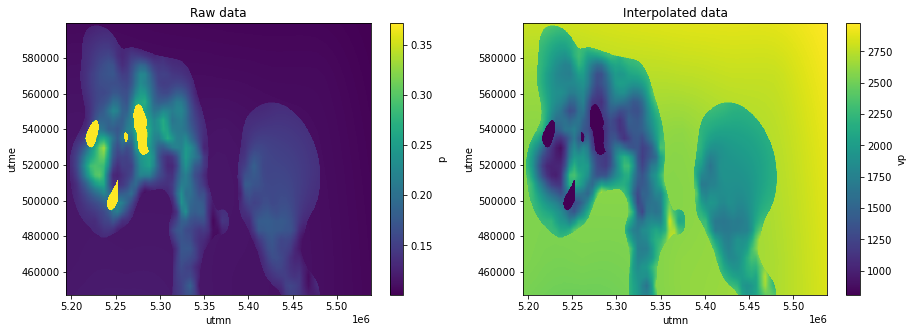

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
newModel.p[:,:,2].plot(ax=axes[0])
axes[0].set_title("Raw data")
DSi.vp[:,:,2].plot(ax=axes[1])
axes[1].set_title("Interpolated data")

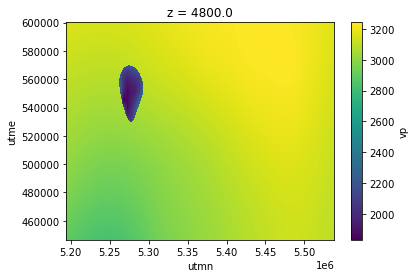

In [12]:
L2.vp[:,:,11].plot()
# plt.gca().invert_yaxis()
# # plt.gca()

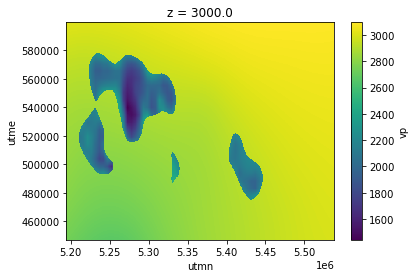

In [13]:
DSi.vp[:,:,10].plot()

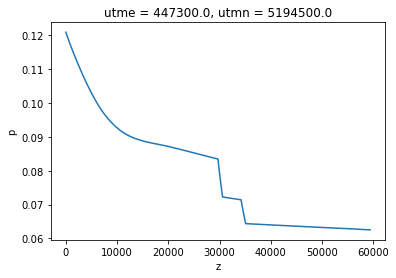

In [14]:
newModel.p[0][0].plot()

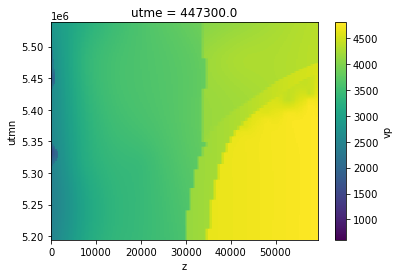

In [15]:
DSi.vp[0].plot()

In [16]:
# dsi.vp.plot(x="utme", y="utmn", col="z",col_wrap = 4)
# plt.grid(color='r', linestyle='-', linewidth=2)
# # plt.savefig('/Users/banjo/Projects/nll_pnsn/figures/nll_py/plotL1_slices.png')
# # plt.draw()

### Part 3 : UTM/LALO converter 
switch back and forth more easily. 

In [1]:
# UTM and LatLon converter - have to pick one of the two either from latlon or to latlon.then run it. 
def find_origin(x,y):
    #utmCoords = utm.from_latlon(x,y)
    laloCoords = utm.to_latlon(x,y, 10, 'T') 
    return laloCoords # utmCoords

find_origin(min_utme,min_utmn)

NameError: name 'min_utme' is not defined

In [18]:
# find_origin(447300,5194500)